In [12]:
!pip install pycountry_convert

In [7]:
from pyspark.sql import SparkSession

# 1. Iniciar Sesión de Spark
spark = SparkSession.builder.appName("ETL_MySQL_to_Bronze").getOrCreate()
print("✅ Sesión de Spark iniciada.")

# 2. Configurar la Conexión a MySQL
# El hostname 'mysql-db' es el nombre del servicio en tu docker-compose.yml
db_name = "importar" # Use your actual database name
db_url = f"jdbc:mysql://host.docker.internal:3306/{db_name}"
db_properties = {
    "user": "root",
    "password": "1234", # La misma contraseña que pusiste en el docker-compose.yml
    "driver": "com.mysql.cj.jdbc.Driver"
}

# 3. Leer la Tabla de MySQL
table_to_ingest = "online retail (3)"
# Usamos una subconsulta para manejar el nombre de tabla con espacios
query = f"(SELECT * FROM `{table_to_ingest}`) AS t"

try:
    print(f"📖 Leyendo la tabla '{table_to_ingest}' desde MySQL...")
    df = spark.read.jdbc(url=db_url, table=query, properties=db_properties)
    print("✅ Lectura desde MySQL exitosa.")
    df.printSchema()

    # 4. Escribir los Datos en la Capa Bronce (Formato Parquet)
    # Los datos se guardarán dentro de la carpeta 'work' para que puedas verlos
    # en tu PC. La ruta es relativa al notebook.
    bronze_path = "bronze/online_retail" 
    
    print(f"💾 Guardando datos en formato Parquet en la ruta: {bronze_path}")
    
    # mode("overwrite") reemplazará los datos si ya existen.
    df.write.mode("overwrite").parquet(bronze_path)
    
    print("🎉 ¡Capa Bronce creada exitosamente!")
    df.show(5)

except Exception as e:
    print("❌ Ocurrió un error:", e)

✅ Sesión de Spark iniciada.
📖 Leyendo la tabla 'online retail (3)' desde MySQL...
✅ Lectura desde MySQL exitosa.
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceDate_dt: timestamp (nullable = true)

💾 Guardando datos en formato Parquet en la ruta: bronze/online_retail
🎉 ¡Capa Bronce creada exitosamente!
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|     InvoiceDate_dt|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, round

# --- Iniciar Sesión de Spark con la configuración COMPLETA de Delta ---
spark = SparkSession.builder \
    .appName("ETL_Bronze_to_Silver_Final") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()

print("✅ Sesión de Spark iniciada con Delta Lake.")

try:
    # 2. Leer los datos crudos desde la capa Bronce
    bronze_path = "bronze/online_retail"
    df_bronze = spark.read.parquet(bronze_path)
    print("📖 Lectura de la capa Bronce (Parquet) exitosa.")

    # 3. Aplicar transformaciones
    print("⚙️  Transformando datos para la Capa Silver...")
    df_silver = df_bronze \
        .filter(col("CustomerID").isNotNull()) \
        .filter(col("Quantity") > 0) \
        .filter(col("UnitPrice") > 0) \
        .withColumn("TotalSales", round(col("Quantity") * col("UnitPrice"), 2)) \
        .withColumn("Año", year(col("InvoiceDate_dt"))) \
        .withColumn("Mes", month(col("InvoiceDate_dt"))) \
        .select(
            col("Año"),
            col("Mes"),
            col("Country"),
            col("CustomerID").alias("CustomerId"),
            col("UnitPrice"),
            col("Quantity"),
            col("TotalSales")
        )
    print("✅ Transformaciones completadas.")

    # 4. Guardar el resultado como una tabla Delta en la Capa Silver
    silver_path = "silver/online_sales"
    print(f"💾 Guardando datos en formato Delta Lake en: {silver_path}")
    df_silver.write.format("delta").mode("overwrite").save(silver_path)
    print("🎉 ¡Capa Silver creada exitosamente!")

    # 5. Mostrar el resultado para verificar
    print("--- Muestra de la Capa Silver (Corregida) ---")
    df_silver.show(10)
    df_silver.printSchema()

except Exception as e:
    print("❌ Ocurrió un error:", e)

✅ Sesión de Spark iniciada con Delta Lake.
📖 Lectura de la capa Bronce (Parquet) exitosa.
⚙️  Transformando datos para la Capa Silver...
✅ Transformaciones completadas.
💾 Guardando datos en formato Delta Lake en: silver/online_sales
🎉 ¡Capa Silver creada exitosamente!
--- Muestra de la Capa Silver (Corregida) ---
+----+---+--------------+----------+---------+--------+----------+
| Año|Mes|       Country|CustomerId|UnitPrice|Quantity|TotalSales|
+----+---+--------------+----------+---------+--------+----------+
|2010| 12|United Kingdom|     17850|     2.55|       6|      15.3|
|2010| 12|United Kingdom|     17850|     3.39|       6|     20.34|
|2010| 12|United Kingdom|     17850|     2.75|       8|      22.0|
|2010| 12|United Kingdom|     17850|     3.39|       6|     20.34|
|2010| 12|United Kingdom|     17850|     3.39|       6|     20.34|
|2010| 12|United Kingdom|     17850|     7.65|       2|      15.3|
|2010| 12|United Kingdom|     17850|     4.25|       6|      25.5|
|2010| 12|Unite

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, round, expr, to_date, date_format, lit, concat, lpad
from pyspark.sql.types import StringType
import pycountry_convert as pc

# Inicia la sesión de Spark (con Delta ya configurado en tu Dockerfile)
spark = SparkSession.builder.appName("ETL_Silver_to_Gold").getOrCreate()
print("✅ Sesión de Spark iniciada.")

# Leemos los datos de la capa Silver que creamos en el paso anterior
silver_path = "silver/online_sales"
df_silver = spark.read.format("delta").load(silver_path)
print("📖 Lectura de la capa Silver (Delta) exitosa.")

# --- 2. Creación de la Tabla Gold: Countries ---

print("\n⚙️  Creando tabla Gold: Countries...")

# Función de Python para convertir país a continente
def country_to_continent(country):
    try:
        # Casos especiales que la librería no reconoce
        if country == 'United Kingdom':
            return 'Europe'
        if country == 'USA':
            return 'North America'
        
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Unknown' # Si no se encuentra el país

# Registramos la función como una UDF (User Defined Function) de Spark
spark.udf.register("country_to_continent_udf", country_to_continent, StringType())

# Creamos el DataFrame de países y continentes
df_countries = df_silver.select("Country").distinct() \
    .withColumn("Continent", expr("country_to_continent_udf(Country)"))

# Guardamos la tabla
df_countries.write.format("delta").mode("overwrite").save("gold/countries")
print("🎉 Tabla 'Countries' creada en la capa Gold.")
df_countries.show()


# --- 3. Creación de la Tabla Gold: Dates ---

print("\n⚙️  Creando tabla Gold: Dates...")

# Creamos una tabla de fechas única a partir de los años y meses de nuestros datos
df_dates = df_silver.select("Año", "Mes").distinct() \
    .withColumn("Fecha", to_date(concat(col("Año"), lit("-"), col("Mes")), "yyyy-M"))

# Añadimos las columnas extra que necesitas
df_dates = df_dates \
    .withColumn("NombreMes", date_format(col("Fecha"), "MMMM")) \
    .withColumn("Periodo", date_format(col("Fecha"), "yyyy-MM")) \
    .withColumnRenamed("Mes", "NumeroMes") \
    .withColumn("NombreDia", date_format(col("Fecha"), "EEEE")) # Nota: Será el nombre del primer día del mes

df_dates.write.format("delta").mode("overwrite").save("gold/dates")
print("🎉 Tabla 'Dates' creada en la capa Gold.")
df_dates.show()


# --- 4. Creación de Tablas Agregadas de Ventas ---

# Ventas por País
print("\n⚙️  Creando tabla Gold: Ventas por País...")
df_sales_by_country = df_silver.groupBy("Country") \
    .agg(round(spark_sum("TotalSales"), 2).alias("TotalVentas")) \
    .orderBy(col("TotalVentas").desc())
df_sales_by_country.write.format("delta").mode("overwrite").save("gold/sales_by_country")
print("🎉 Tabla 'Ventas por País' creada.")
df_sales_by_country.show(10)

# Ventas por Cliente
print("\n⚙️  Creando tabla Gold: Ventas por Cliente...")
df_sales_by_customer = df_silver.groupBy("CustomerId") \
    .agg(round(spark_sum("TotalSales"), 2).alias("TotalVentas")) \
    .orderBy(col("TotalVentas").desc())
df_sales_by_customer.write.format("delta").mode("overwrite").save("gold/sales_by_customer")
print("🎉 Tabla 'Ventas por Cliente' creada.")
df_sales_by_customer.show(10)

# Ventas por Periodo
print("\n⚙️  Creando tabla Gold: Ventas por Periodo...")
df_sales_by_period = df_silver \
    .withColumn("Periodo", concat(col("Año"), lit("-"), lpad(col("Mes"), 2, '0'))) \
    .groupBy("Periodo") \
    .agg(round(spark_sum("TotalSales"), 2).alias("TotalVentas")) \
    .orderBy("Periodo")
df_sales_by_period.write.format("delta").mode("overwrite").save("gold/sales_by_period")
print("🎉 Tabla 'Ventas por Periodo' creada.")
df_sales_by_period.show(10)

✅ Sesión de Spark iniciada.
📖 Lectura de la capa Silver (Delta) exitosa.

⚙️  Creando tabla Gold: Countries...
🎉 Tabla 'Countries' creada en la capa Gold.
+------------------+---------+
|           Country|Continent|
+------------------+---------+
|            Sweden|   Europe|
|         Singapore|     Asia|
|           Germany|   Europe|
|               RSA|  Unknown|
|            France|   Europe|
|            Greece|   Europe|
|European Community|  Unknown|
|           Belgium|   Europe|
|           Finland|   Europe|
|             Malta|   Europe|
|       Unspecified|  Unknown|
|             Italy|   Europe|
|              EIRE|  Unknown|
|         Lithuania|   Europe|
|            Norway|   Europe|
|             Spain|   Europe|
|           Denmark|   Europe|
|         Hong Kong|     Asia|
|           Iceland|   Europe|
|            Israel|     Asia|
+------------------+---------+
only showing top 20 rows


⚙️  Creando tabla Gold: Dates...
🎉 Tabla 'Dates' creada en la capa Gold.
+

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round

spark = SparkSession.builder.appName("Final_Gold_Customers").getOrCreate()
print("✅ Sesión de Spark iniciada.")

try:
    # 1. Leer la tabla de clientes desde MySQL
    print("📖 Leyendo la tabla de clientes desde MySQL...")
    df_customer_details = spark.read.jdbc(
        url=db_url, 
        table="`online retail clients`",
        properties=db_properties
    )

    # 2. LA SOLUCIÓN: Renombrar la columna con espacio 
    df_customer_details = df_customer_details.withColumnRenamed("Customer Name", "CustomerName")
    print("⚙️  Columna 'Customer Name' renombrada a 'CustomerName'.")

    # 3. Leer la tabla agregada de ventas desde la capa Gold
    print("📖 Leyendo agregados de ventas desde 'gold/sales_by_customer'...")
    sales_by_customer_path = "gold/sales_by_customer"
    df_sales_by_customer = spark.read.format("delta").load(sales_by_customer_path)

    # 4. Unir (Join) los detalles del cliente con sus ventas totales
    print("⚙️  Uniendo detalles de clientes con sus ventas...")
    df_customers_gold = df_customer_details.join(
        df_sales_by_customer,
        # Aseguramos que los nombres de columna coincidan
        df_customer_details.CustomerID == df_sales_by_customer.CustomerId,
        "left"
    ).select(
        df_customer_details.CustomerID,
        df_customer_details.CustomerName, # Ahora usamos el nombre sin espacio
        df_sales_by_customer.TotalVentas
    )
    
    # 5. Guardar la tabla final en la capa Gold
    customers_gold_path = "gold/customers"
    print(f"💾 Guardando tabla de clientes enriquecida en: {customers_gold_path}")
    
    df_customers_gold.write.format("delta") \
        .mode("overwrite") \
        .option("overwriteSchema", "true") \
        .save(customers_gold_path)
    
    print("🎉 Tabla 'Customers' creada exitosamente en la capa Gold.")
    df_customers_gold.show(10, truncate=False)

except Exception as e:
    print("❌ Ocurrió un error:", e)

✅ Sesión de Spark iniciada.
📖 Leyendo la tabla de clientes desde MySQL...
⚙️  Columna 'Customer Name' renombrada a 'CustomerName'.
📖 Leyendo agregados de ventas desde 'gold/sales_by_customer'...
⚙️  Uniendo detalles de clientes con sus ventas...
💾 Guardando tabla de clientes enriquecida en: gold/customers
🎉 Tabla 'Customers' creada exitosamente en la capa Gold.
+----------+----------------------------+-----------+
|CustomerID|CustomerName                |TotalVentas|
+----------+----------------------------+-----------+
|17850     |Client with Name ABC - 17850|10782.42   |
|13047     |Client with Name ABC - 13047|3604.17    |
|12583     |Client with Name ABC - 12583|8137.24    |
|13748     |Client with Name ABC - 13748|1152.25    |
|15100     |Client with Name ABC - 15100|1576.8     |
|15291     |Client with Name ABC - 15291|4997.1     |
|14688     |Client with Name ABC - 14688|6075.85    |
|17809     |Client with Name ABC - 17809|6663.41    |
|15311     |Client with Name ABC - 15311|6

📖 Cargando datos de la Capa Gold...
⚙️  Convirtiendo a Pandas...
📊 Creando el dashboard...


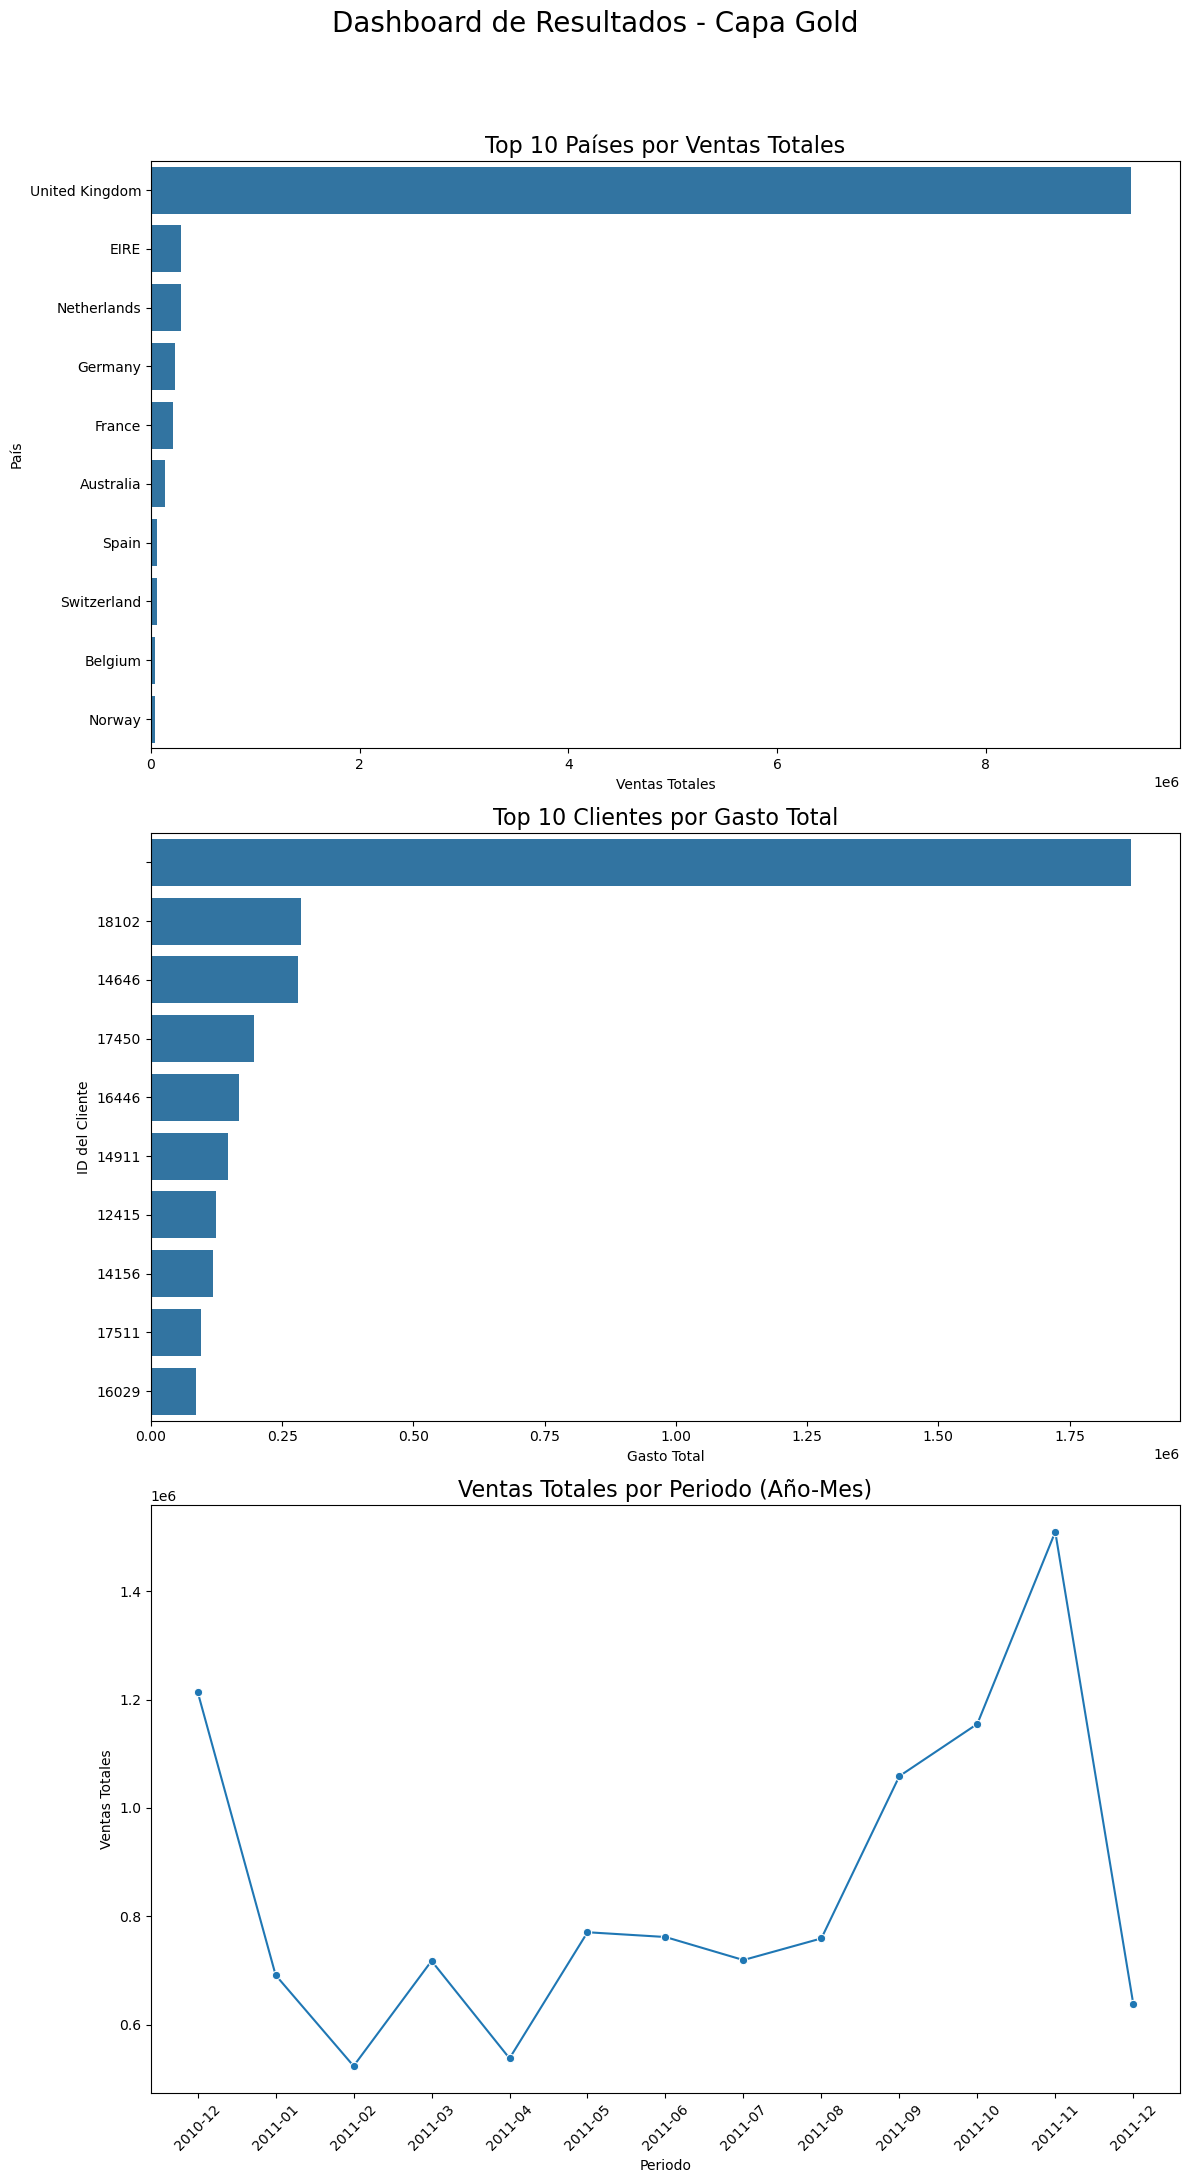

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# --- 1. Cargar todas las tablas de la Capa Gold ---
print("📖 Cargando datos de la Capa Gold...")
sales_by_country_df = spark.read.format("delta").load("gold/sales_by_country")
sales_by_customer_df = spark.read.format("delta").load("gold/sales_by_customer")
sales_by_period_df = spark.read.format("delta").load("gold/sales_by_period")

# --- 2. Convertir a Pandas para poder graficar ---
# Advertencia: Solo haz esto con tablas agregadas y pequeñas.
print("⚙️  Convirtiendo a Pandas...")
pd_by_country = sales_by_country_df.orderBy(col("TotalVentas").desc()).limit(10).toPandas()
pd_by_customer = sales_by_customer_df.orderBy(col("TotalVentas").desc()).limit(10).toPandas()
pd_by_period = sales_by_period_df.orderBy("Periodo").toPandas()

# --- 3. Crear el Dashboard con 3 Gráficos ---
print("📊 Creando el dashboard...")

# Creamos una figura grande que contendrá 3 gráficos (3 filas, 1 columna)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 22))
fig.suptitle('Dashboard de Resultados - Capa Gold', fontsize=20, y=1.02)


# Gráfico 1: Top 10 Países por Ventas
sns.barplot(ax=axes[0], data=pd_by_country, x="TotalVentas", y="Country", orient='h')
axes[0].set_title('Top 10 Países por Ventas Totales', fontsize=16)
axes[0].set_xlabel('Ventas Totales')
axes[0].set_ylabel('País')

# Gráfico 2: Top 10 Clientes por Ventas
# Convertimos CustomerId a string para que el gráfico lo trate como una categoría
pd_by_customer['CustomerId'] = pd_by_customer['CustomerId'].astype(str)
sns.barplot(ax=axes[1], data=pd_by_customer, x="TotalVentas", y="CustomerId", orient='h')
axes[1].set_title('Top 10 Clientes por Gasto Total', fontsize=16)
axes[1].set_xlabel('Gasto Total')
axes[1].set_ylabel('ID del Cliente')

# Gráfico 3: Ventas a lo largo del Tiempo
sns.lineplot(ax=axes[2], data=pd_by_period, x="Periodo", y="TotalVentas", marker='o')
axes[2].set_title('Ventas Totales por Periodo (Año-Mes)', fontsize=16)
axes[2].set_xlabel('Periodo')
axes[2].set_ylabel('Ventas Totales')
# Rotamos las etiquetas del eje X para que se lean mejor
axes[2].tick_params(axis='x', rotation=45)


# Ajustamos el espaciado y mostramos la figura final
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()